In [1]:
import numpy as np
import pandas as pd
import emcee
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer

In [11]:
# Define the log prior
def log_prior(theta):
    mu, sigma = theta
    if 0 < sigma < 10:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

# Define log likelihood
def d_L(h, z, o_m, o_l):

    # Hubble distance
    d_H = 2997.92458/h
    
    # Comoving distance
    d_C = lambda omega_m, omega_lambda, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda - omega_r) * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
    d_C = cumulative_trapezoid(d_C(o_m, o_l), z, initial=0) 
    d_C[np.isnan(d_C)] = 0
        
    omega_m = o_m
    omega_lambda = o_l
    omega_r = 9.e-5
    omega_k = 1 - omega_m - omega_lambda - omega_r
    
    # Transverse comoving distance:
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 

    if omega_k == 0:
        d_M = d_C

    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    d_L = (1 + z) * d_M

    return d_L

def distance_modulus(h, z, omega_m, omega_l):
    dl = d_L(h, z, omega_m, omega_l)
    dis_mod = 5 * np.log10(dl) + 25
    return dis_mod

def chi_square(y_model, y, yerr):
    p = (y - y_model)**2/(yerr)**2
    return p 

def log_likelihood(theta, data):
    omega_m, omega_l = theta
    z_array = data['redshift'].to_numpy()
    mag_array =  data['magnitude'].to_numpy()
    mag_err = data['error_magnitude'].to_numpy()
    h = 0.7
    z = np.linspace(0, 2, 1000)
    
    model1 = distance_modulus(h, z, omega_m, omega_l)
    func_model1 = interp1d(z, model1)
    model2 = func_model1(z_array)
    post = chi_square(model2, mag_array, mag_err)
    chi2 = np.sum(post)
    return -chi2/2 

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)


In [12]:
# SNe Data
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)
data = df

# Number of dimensions (h, omega_m, omega_l)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 6

# Initial positions of the walkers (random guesses)
initial_guesses = np.random.rand(nwalkers, ndim)
print(initial_guesses)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])

[[0.02816993 0.07319526]
 [0.72796983 0.21361087]
 [0.85553701 0.70096749]
 [0.13925826 0.73053358]
 [0.21832089 0.7706956 ]
 [0.0522641  0.71779125]]


In [13]:
# Run the MCMC for 500 steps
nsteps = 100000
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10979/2840182599.py:40: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:09<00:00, 771.34it/s]


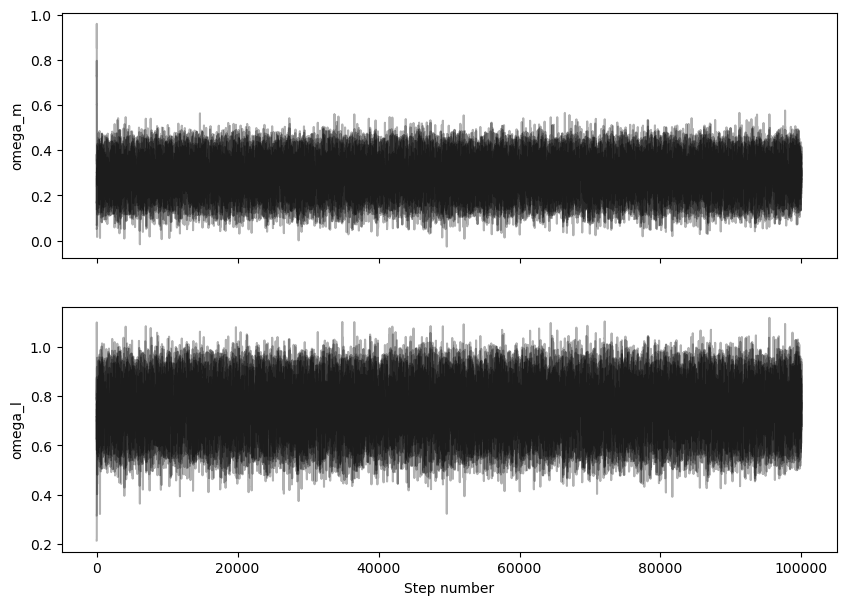

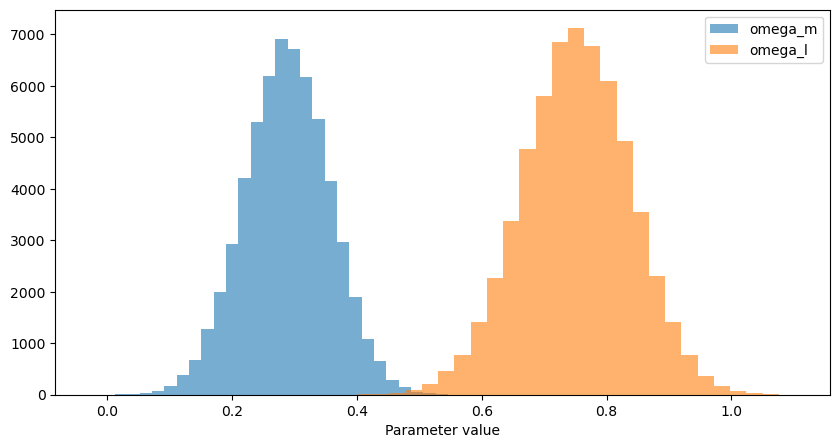

In [14]:
# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [ "omega_m", "omega_l"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="omega_m")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="omega_l")
plt.xlabel("Parameter value")
plt.legend()
plt.show()

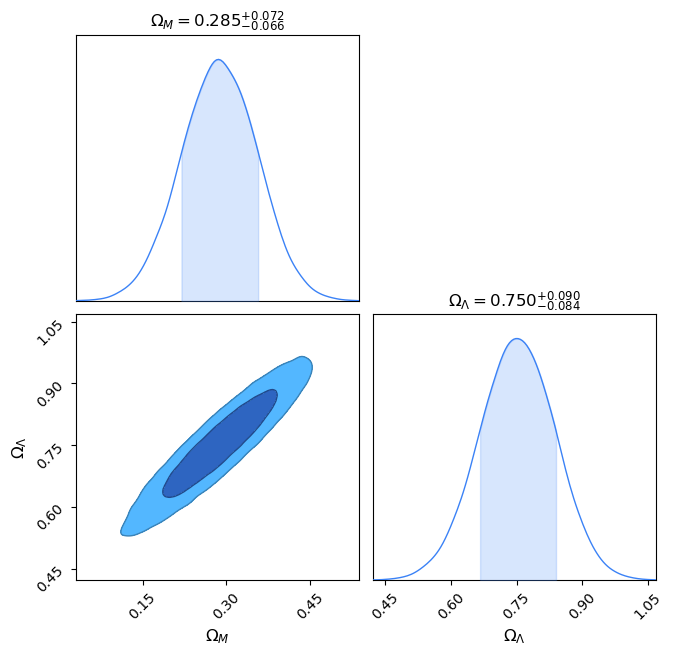

In [15]:
df1 = pd.DataFrame(flat_samples, columns = ['$\Omega_M$', '$\Omega_\Lambda$'])
#print(df1)
c = ChainConsumer()
c.add_chain(Chain(samples=df1, name="An Example Contour"))
#c.add_chain(flat_samples)
fig = c.plotter.plot()

In [16]:
### SAVE RESULTS ####

df1.to_csv("omega_m_omega_l-curved_universe_EMCEE.csv", index=False)

## Gelman-Rubin Test

In [17]:
'''def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin statistic (R-hat) for MCMC chains.
    Args:
        chains: A numpy array of shape (nsteps, nwalkers, ndim).
    Returns:
        r_hat: A numpy array of the R-hat statistic for each parameter.
    """
    # Number of steps, number of walkers, and number of parameters
    nsteps, nwalkers = chains.shape

    # Mean of each walker (over the steps)
    walker_means = np.mean(chains, axis=0)  # shape: (nwalkers, ndim)
    
    # Mean of all samples for each parameter
    global_mean = np.mean(walker_means, axis=0)  # shape: (ndim,)

    # Between-chain variance B
    B = nsteps * np.sum((walker_means - global_mean) ** 2, axis=0) / (nwalkers - 1)
    
    # Within-chain variance W
    W = np.sum(np.var(chains, axis=0, ddof=1), axis=0) / nwalkers
    
    # Estimate of marginal posterior variance
    V_hat = (W * (nsteps - 1) + B) / nsteps

    # Compute the R-hat statistic
    r_hat = np.sqrt(V_hat / W)
    
    return r_hat'''

'def gelman_rubin(chains):\n    """\n    Calculate the Gelman-Rubin statistic (R-hat) for MCMC chains.\n    Args:\n        chains: A numpy array of shape (nsteps, nwalkers, ndim).\n    Returns:\n        r_hat: A numpy array of the R-hat statistic for each parameter.\n    """\n    # Number of steps, number of walkers, and number of parameters\n    nsteps, nwalkers = chains.shape\n\n    # Mean of each walker (over the steps)\n    walker_means = np.mean(chains, axis=0)  # shape: (nwalkers, ndim)\n    \n    # Mean of all samples for each parameter\n    global_mean = np.mean(walker_means, axis=0)  # shape: (ndim,)\n\n    # Between-chain variance B\n    B = nsteps * np.sum((walker_means - global_mean) ** 2, axis=0) / (nwalkers - 1)\n    \n    # Within-chain variance W\n    W = np.sum(np.var(chains, axis=0, ddof=1), axis=0) / nwalkers\n    \n    # Estimate of marginal posterior variance\n    V_hat = (W * (nsteps - 1) + B) / nsteps\n\n    # Compute the R-hat statistic\n    r_hat = np.sqrt(V_ha

In [18]:
def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin statistic (R_hat) for MCMC chains.
    
    Parameters:
    -----------
    chains : numpy array of shape (n_chains, n_samples, n_params)
        MCMC chains. Should be an array where each row represents a chain, 
        and each column represents samples for a parameter.
    
    Returns:
    --------
    R_hat : numpy array of shape (n_params,)
        Gelman-Rubin R-hat statistic for each parameter.
    """
    
    # Number of chains, number of samples, and number of parameters
    m, n = chains.shape
    
    # Step 1: Mean of each chain for each parameter (shape: m x p)
    chain_means = np.mean(chains, axis=1)
    
    # Step 2: Variance within each chain (shape: m x p)
    chain_vars = np.var(chains, axis=1, ddof=1)
    
    # Step 3: Overall mean of the chains (shape: p,)
    overall_mean = np.mean(chain_means, axis=0)
    
    # Step 4: Between-chain variance (B) (shape: p,)
    B = n * np.var(chain_means, axis=0, ddof=1)
    
    # Step 5: Within-chain variance (W) (shape: p,)
    W = np.mean(chain_vars, axis=0)
    
    # Step 6: Estimate of the variance of the target distribution
    var_hat = (n - 1) / n * W + (1 / n) * B
    
    # Step 7: Calculate R_hat (shape: p,)
    R_hat = np.sqrt(var_hat / W)
    
    return R_hat

In [19]:
# Calculate the Gelman-Rubin R-hat statistic
r_hat = gelman_rubin(flat_samples)

# Print the R-hat statistic for each parameter
print("Gelman-Rubin R-hat values for each parameter:", r_hat)

Gelman-Rubin R-hat values for each parameter: 0.7440540024483442


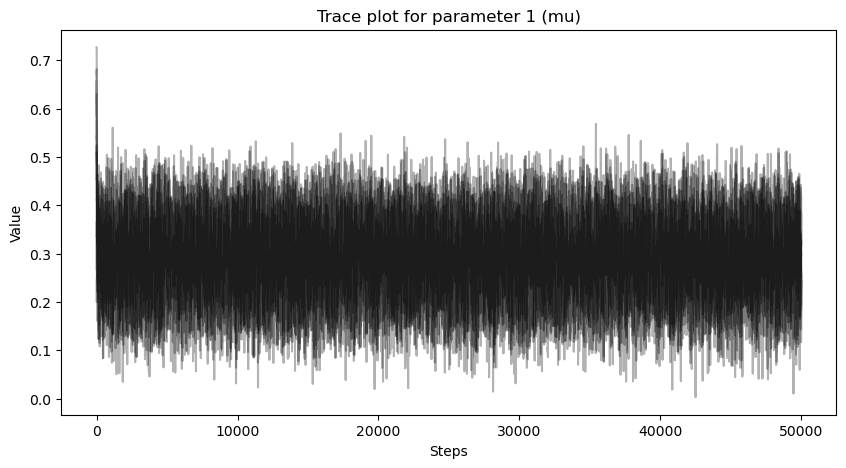

In [71]:
# Plot the trace of the first parameter (mu) for all walkers
plt.figure(figsize=(10, 5))
for walker in range(samples.shape[1]):
    plt.plot(samples[:, walker, 0], color="k", alpha=0.3)
plt.title("Trace plot for parameter 1 (mu)")
plt.xlabel("Steps")
plt.ylabel("Value")
plt.show()